### Task 1: Dataset 2

In [40]:
import numpy as np
import torch.autograd
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import os
from IPython.display import Image, display

In [3]:
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

In [4]:
from numpy.linalg import inv

x0=np.ones(num_samples)
X=np.hstack((x0.reshape(num_samples,1),x1.reshape(num_samples,1)))
print(X.shape)

T=inv(X.T@X)@X.T@y

print("Theta matrix: ",end="")
print(T)

min_t0=T[0]
min_t1=T[1]

min_loss=0
for i in range(num_samples):
    yp= min_t0 + min_t1*x1[i]
    min_loss += (y[i]-yp)**2
min_loss=min_loss/num_samples

print(f"Min Loss: {min_loss}")

(40, 2)
Theta matrix: [3.9507064  2.68246893]
Min Loss: 0.5957541565733318


In [5]:
def full_batch_gd(x, y, alpha=0.001, epochs=1000, epsilon=1e-3, start_theta=(1.0, 1.0), min_loss=None):
    """
    Performs Full Batch Gradient Descent on y = t0 + t1*x
    Returns trajectory, loss dict, convergence info
    """
    t0 = torch.tensor(start_theta[0], requires_grad=True)
    t1 = torch.tensor(start_theta[1], requires_grad=True)
    num_samples = len(x)

    t0_values, t1_values, loss_values = [], [], []
    loss_dict = {}

    for epoch in range(1, epochs + 1):
        yp = t0 + t1 * x
        loss = torch.mean((y - yp) ** 2)
        loss.backward()
        # Store data
        loss_dict[epoch] = loss.item()
        with torch.no_grad():
            t0 -= alpha * t0.grad
            t1 -= alpha * t1.grad

        
        t0_values.append(t0.item())
        t1_values.append(t1.item())
        loss_values.append(loss.item())

        # Reset gradients
        t0.grad.zero_()
        t1.grad.zero_()

    # Convergence detection
    converge_epoch, converge_loss = None, None
    if min_loss is not None:
        for epoch in loss_dict.keys():
            if abs(loss_dict[epoch] - min_loss) <= epsilon:
                converge_epoch = epoch
                converge_loss = loss_dict[epoch]
                break
              
    return {
        "t0_values": t0_values,
        "t1_values": t1_values,
        "loss_values": loss_values,
        "loss_dict": loss_dict,
        "final_t0": t0.item(),
        "final_t1": t1.item(),
        "converge_epoch": converge_epoch,
        "converge_loss": converge_loss,
    }

In [6]:
def plot_loss_vs_epoch(loss_dict, converge_epoch=None, converge_loss=None):
    plt.figure(figsize=(6, 4))
    plt.plot(loss_dict.keys(), loss_dict.values(), label='Loss Curve')
    if converge_epoch is not None:
        plt.plot(converge_epoch, converge_loss, 'ro', label='Convergence Point')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

### Plot of Loss vs Epoch for Full Batch Gradient Descent

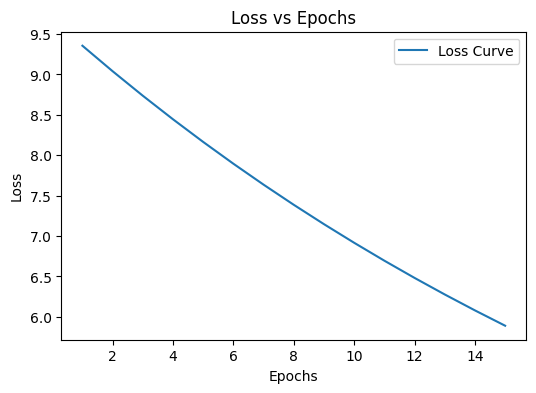

In [7]:

# Convert x1, y to PyTorch tensors
x_tensor = torch.tensor(x1, dtype=torch.float64)
y_tensor = torch.tensor(y, dtype=torch.float64)

# Run Gradient Descent
res = full_batch_gd(
    x_tensor, y_tensor,
    alpha=0.01, epochs=15, epsilon=0.01,
    start_theta=(1.0, 1.0), min_loss=min_loss
)

# Plot results
plot_loss_vs_epoch(res["loss_dict"], res["converge_epoch"], res["converge_loss"])

584


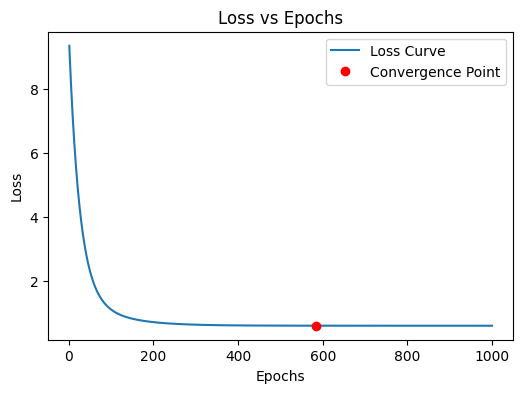

In [8]:
res = full_batch_gd(
    x_tensor, y_tensor,
    alpha=0.01, epochs=1000, epsilon=0.001,
    start_theta=(1.0, 1.0), min_loss=min_loss
)
print(res["converge_epoch"])
# Plot results
plot_loss_vs_epoch(res["loss_dict"], res["converge_epoch"], res["converge_loss"])

### Contour Plot for Full Batch Gradient Descent

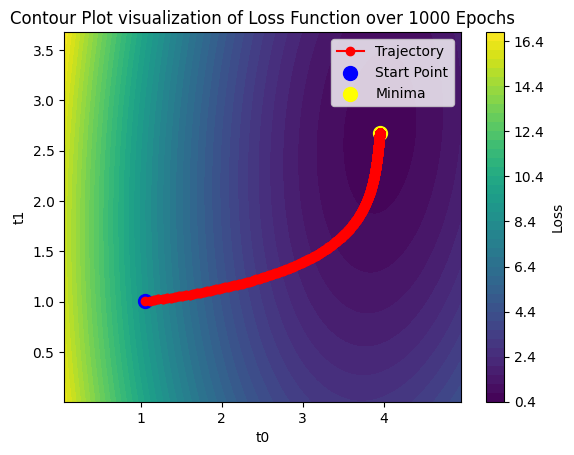

C:\Users\seema\AppData\Local\Temp\ipykernel_16872\3438717558.py:80: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved permanently at: results\trajectory_bgd_no_momentum.gif


In [9]:
t0_values = res['t0_values']
t1_values = res['t1_values']
loss_values = res['loss_values']

# If you want the final minimum point
min_t0 = res['final_t0']
min_t1 = res['final_t1']
t0_grid = np.linspace(min(t0_values) - 1, max(t0_values) + 1, 100)
t1_grid = np.linspace(min(t1_values) - 1, max(t1_values) + 1, 100)
T0, T1 = np.meshgrid(t0_grid, t1_grid)

# Calculate the loss function at each point of the grid
loss_grid = np.zeros_like(T0)
for i in range(len(t0_grid)):
    for j in range(len(t1_grid)):
        loss_grid[i, j] = np.mean((y - (T0[i, j] + T1[i, j] * x1)) ** 2)

# Plotting the contour map
plt.contourf(T0, T1, loss_grid, levels=50, cmap='viridis')
plt.colorbar(label='Loss')

# Plot the trajectory of t0 and t1 during the 2500 epochs
plt.plot(t0_values, t1_values, marker='o', color='red', label='Trajectory')
plt.scatter(t0_values, t1_values, c='red')
plt.xlabel("t0")
plt.ylabel("t1")
plt.title("Contour Plot visualization of Loss Function over 1000 Epochs")
plt.legend()

# Mark the starting point and the minima point
plt.scatter(t0_values[0], t1_values[0], c='blue', s=100, label='Start Point')  # Start
plt.scatter(min_t0, min_t1, c='yellow', s=100, label='Minima')  # Minima

plt.legend()
plt.show()

# Create a folder to store frames temporarily
frames_folder = "trajectory_frames"
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

filenames = []

# Plot the trajectory of t0 and t1 during the first 15 epochs
for i in range(15):
    plt.contourf(T0, T1, loss_grid, levels=50, cmap='viridis')
    plt.colorbar(label='Loss')
    
    # Plot trajectory
    plt.plot(t0_values[0:i+1], t1_values[0:i+1], marker='o', color='red', label='Trajectory')
    plt.scatter(t0_values[0:i+1], t1_values[0:i+1], c='red')
    
    plt.xlabel("t0")
    plt.ylabel("t1")
    plt.title(f"Contour Plot of Loss Function over {i+1} Epochs")
    
    # Mark the starting point and the ending point (minimized point)
    plt.scatter(t0_values[0], t1_values[0], c='blue', s=100, label='Start Point')  # Start
    plt.scatter(t0_values[-1], t1_values[-1], c='yellow', s=100, label='Minima')  # Minima

    plt.legend()
    
    # Save the frame
    filename = os.path.join(frames_folder, f"frame_{i:03d}.png")
    plt.savefig(filename)
    filenames.append(filename)
    
    plt.close()

# Create a folder to store the final GIF permanently
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

gif_filename = os.path.join(results_folder, "trajectory_bgd_no_momentum.gif")

# Create the GIF
with imageio.get_writer(gif_filename, mode='I', duration=0.5, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cleanup temporary frames
import shutil

try:
    for filename in filenames:
        os.remove(filename)
    shutil.rmtree(frames_folder, ignore_errors=True)
    print(f"GIF saved permanently at: {gif_filename}")
except Exception as e:
    print(f"Cleanup failed: {e}")


### Average Convergence Steps for Full Batch Gradient Descent

In [10]:
def average_convergence(x, y, start_points, alpha=0.01, epochs=1000, epsilon=1e-3, min_loss=None):
    total_epochs = 0
    valid_runs = 0

    for start_theta in start_points:
        result = full_batch_gd(x, y, alpha, epochs, epsilon, start_theta, min_loss)
        if result["converge_epoch"] is not None:
            total_epochs += result["converge_epoch"]
            valid_runs += 1

    avg_steps = total_epochs / valid_runs if valid_runs > 0 else None
    print(f" Average convergence steps across {valid_runs} runs: {avg_steps}")
    return avg_steps

In [15]:
start_thetas = [(np.random.uniform(-5, 5), np.random.uniform(-5, 5)) for _ in range(5)]
average_convergence(x_tensor, y_tensor, start_thetas, alpha=0.01, epochs=1000, epsilon=0.01, min_loss=min_loss)

 Average convergence steps across 5 runs: 554.6


554.6

### Stochastic Gradient Descent

In [12]:
def stochastic_gd(x, y, alpha=0.01, epochs=50, epsilon=1e-3, start_theta=(1.0, 1.0), min_loss=None):
    """
    Performs Stochastic Gradient Descent (SGD) on y = t0 + t1*x
    Returns trajectory, loss dict, and convergence info
    """
    num_samples = len(x)
    
    # Initialize parameters
    t0 = torch.tensor(start_theta[0], requires_grad=True)
    t1 = torch.tensor(start_theta[1], requires_grad=True)

    # Lists to store the trajectory for plotting
    t0_values, t1_values, loss_values = [], [], []
    loss_dict = {}

    for epoch in range(1, epochs + 1):
        for i in range(num_samples):
            # Compute loss for a single sample
            yp = t0 + t1 * x[i]
            loss = (y[i] - yp) ** 2
            loss.backward()

            # Update parameters
            with torch.no_grad():
                t0 -= alpha * t0.grad
                t1 -= alpha * t1.grad

            # Reset gradients
            t0.grad.zero_()
            t1.grad.zero_()

        # Compute loss for the full dataset after the epoch
        yp_full = t0 + t1 * x
        full_loss = torch.mean((y - yp_full) ** 2)
        loss_dict[epoch] = full_loss.item()

        # Store trajectory
        t0_values.append(t0.item())
        t1_values.append(t1.item())
        loss_values.append(full_loss.item())

        
        

    # Convergence detection
    converge_epoch, converge_loss = None, None
    if min_loss is not None:
        for epoch in loss_dict.keys():
            if abs(loss_dict[epoch] - min_loss) <= epsilon:
                converge_epoch = epoch
                converge_loss = loss_dict[epoch]
                break

    return {
        "t0_values": t0_values,
        "t1_values": t1_values,
        "loss_values": loss_values,
        "loss_dict": loss_dict,
        "final_t0": t0.item(),
        "final_t1": t1.item(),
        "converge_epoch": converge_epoch,
        "converge_loss": converge_loss,
    }


### Plot of Loss vs Epoch for Stochastic Gradient Descent

17


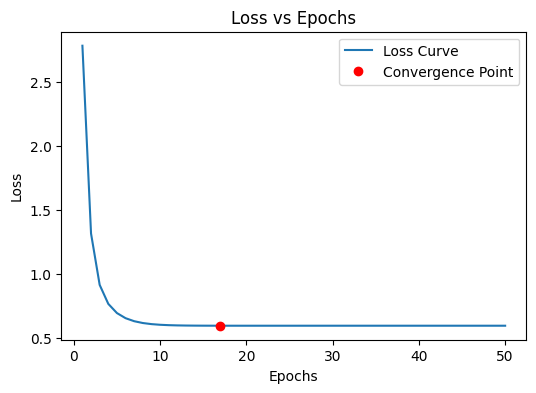

In [13]:
res = stochastic_gd(
    x_tensor, y_tensor,
    alpha=0.01, epochs=50, epsilon=0.001,
    start_theta=(1.0, 1.0), min_loss=min_loss
)
print(res["converge_epoch"])
# Plot results
plot_loss_vs_epoch(res["loss_dict"], res["converge_epoch"], res["converge_loss"])

### Contour Plot for Stochastic gradient Descent

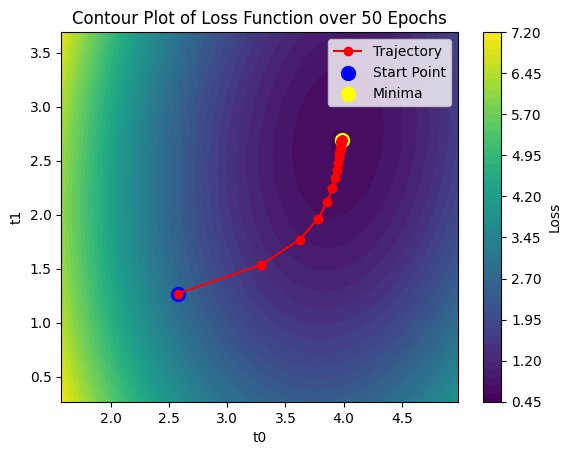

C:\Users\seema\AppData\Local\Temp\ipykernel_16872\235109145.py:80: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved permanently at: results\trajectory_sgd_no_momentum.gif


In [16]:
t0_values = res['t0_values']
t1_values = res['t1_values']
loss_values = res['loss_values']

# If you want the final minimum point
min_t0 = res['final_t0']
min_t1 = res['final_t1']
t0_grid = np.linspace(min(t0_values) - 1, max(t0_values) + 1, 100)
t1_grid = np.linspace(min(t1_values) - 1, max(t1_values) + 1, 100)
T0, T1 = np.meshgrid(t0_grid, t1_grid)

# Calculate the loss function at each point of the grid
loss_grid = np.zeros_like(T0)
for i in range(len(t0_grid)):
    for j in range(len(t1_grid)):
        loss_grid[i, j] = np.mean((y - (T0[i, j] + T1[i, j] * x1)) ** 2)

# Plotting the contour map
plt.contourf(T0, T1, loss_grid, levels=50, cmap='viridis')
plt.colorbar(label='Loss')

# Plot the trajectory of t0 and t1 during the 2500 epochs
plt.plot(t0_values, t1_values, marker='o', color='red', label='Trajectory')
plt.scatter(t0_values, t1_values, c='red')
plt.xlabel("t0")
plt.ylabel("t1")
plt.title("Contour Plot of Loss Function over 50 Epochs")
plt.legend()

# Mark the starting point and the minima point
plt.scatter(t0_values[0], t1_values[0], c='blue', s=100, label='Start Point')  # Start
plt.scatter(min_t0, min_t1, c='yellow', s=100, label='Minima')  # Minima

plt.legend()
plt.show()

# Create a folder to store frames temporarily
frames_folder = "trajectory_frames"
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

filenames = []

# Plot the trajectory of t0 and t1 during the first 15 epochs
for i in range(15):
    plt.contourf(T0, T1, loss_grid, levels=50, cmap='viridis')
    plt.colorbar(label='Loss')
    
    # Plot trajectory
    plt.plot(t0_values[0:i+1], t1_values[0:i+1], marker='o', color='red', label='Trajectory')
    plt.scatter(t0_values[0:i+1], t1_values[0:i+1], c='red')
    
    plt.xlabel("t0")
    plt.ylabel("t1")
    plt.title(f"Contour Plot of Loss Function over {i+1} Epochs")
    
    # Mark the starting point and the ending point (minimized point)
    plt.scatter(t0_values[0], t1_values[0], c='blue', s=100, label='Start Point')  # Start
    plt.scatter(t0_values[-1], t1_values[-1], c='yellow', s=100, label='Minima')  # Minima

    plt.legend()
    
    # Save the frame
    filename = os.path.join(frames_folder, f"frame_{i:03d}.png")
    plt.savefig(filename)
    filenames.append(filename)
    
    plt.close()

# Create a folder to store the final GIF permanently
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

gif_filename = os.path.join(results_folder, "trajectory_sgd_no_momentum.gif")

# Create the GIF
with imageio.get_writer(gif_filename, mode='I', duration=0.5, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cleanup temporary frames
try:
    for filename in filenames:
        os.remove(filename)
    shutil.rmtree(frames_folder, ignore_errors=True)
    print(f"GIF saved permanently at: {gif_filename}")
except Exception as e:
    print(f"Cleanup failed: {e}")


### Average Convergence Steps for Stochastic Gradient Descent

In [18]:
def average_convergence_sgd(x, y, start_points, alpha=0.01, epochs=50, epsilon=1e-3, min_loss=None):
    total_steps = 0
    valid_runs = 0

    for start_theta in start_points:
        result = stochastic_gd(x, y, alpha, epochs, epsilon, start_theta, min_loss)
        if result["converge_epoch"] is not None:
            total_steps += num_samples*result["converge_epoch"]
            valid_runs += 1

    avg_steps = total_steps / valid_runs if valid_runs > 0 else None
    print(f" Average convergence steps across {valid_runs} runs: {avg_steps}")
    return avg_steps

In [19]:
start_thetas = [(np.random.uniform(-5, 5), np.random.uniform(-5, 5)) for _ in range(5)]
average_convergence_sgd(x_tensor, y_tensor, start_thetas, alpha=0.01, epochs=50, epsilon=0.001, min_loss=min_loss)

 Average convergence steps across 5 runs: 688.0


688.0

### Gradient Descent with momentum

In [20]:
def full_batch_gd_momentum(x, y, alpha=0.01, momentum=0.9, epochs=100, epsilon=1e-3, start_theta=(1.0, 1.0), min_loss=None):
    """
    Performs Full Batch Gradient Descent with Momentum on y = t0 + t1*x
    Returns trajectory, loss dict, convergence info
    """
    num_samples = len(x)
    
    # Initialize parameters
    t0 = torch.tensor(start_theta[0], requires_grad=True)
    t1 = torch.tensor(start_theta[1], requires_grad=True)
    
    # Initialize momentum velocities
    v_t0 = torch.tensor(0.0)
    v_t1 = torch.tensor(0.0)
    
    # Lists to store trajectory
    t0_values, t1_values, loss_values = [], [], []
    t0_grad, t1_grad = [], []
    velocity_t0, velocity_t1 = [], []
    loss_dict = {}
    
    for epoch in range(1, epochs + 1):
        # Compute full batch loss
        yp = t0 + t1 * x
        loss = torch.mean((y - yp) ** 2)
        loss.backward()
        
        # Store gradients and velocities
        with torch.no_grad():
            # Update velocities
            v_t0 = momentum * v_t0 + alpha * t0.grad
            v_t1 = momentum * v_t1 + alpha * t1.grad
            
            # Update parameters
            t0 -= v_t0
            t1 -= v_t1
            
            t0_grad.append(t0.grad.item())
            t1_grad.append(t1.grad.item())
            velocity_t0.append(v_t0.item())
            velocity_t1.append(v_t1.item())
        
        # Store trajectory and loss
        t0_values.append(t0.item())
        t1_values.append(t1.item())
        loss_values.append(loss.item())
        loss_dict[epoch] = loss.item()
        
        # Reset gradients
        t0.grad.zero_()
        t1.grad.zero_()
    
    # Convergence detection
    converge_epoch, converge_loss = None, None
    if min_loss is not None:
        for epoch in loss_dict.keys():
            if abs(loss_dict[epoch] - min_loss) <= epsilon:
                converge_epoch = epoch
                converge_loss = loss_dict[epoch]
                break
    
    return {
        "t0_values": t0_values,
        "t1_values": t1_values,
        "loss_values": loss_values,
        "loss_dict": loss_dict,
        "t0_grad": t0_grad,
        "t1_grad": t1_grad,
        "velocity_t0": velocity_t0,
        "velocity_t1": velocity_t1,
        "final_t0": t0.item(),
        "final_t1": t1.item(),
        "converge_epoch": converge_epoch,
        "converge_loss": converge_loss,
    }


### Plot of Loss Vs Epochs for Full Batch Gradient Descent with momentum=0.9

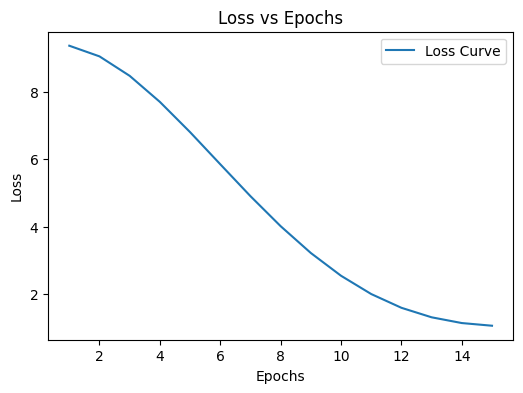

In [21]:
res = full_batch_gd_momentum(
    x_tensor, y_tensor,
    alpha=0.01,momentum=0.9, epochs=15, epsilon=0.001,
    start_theta=(1.0, 1.0), min_loss=min_loss
)

# Plot results
plot_loss_vs_epoch(res["loss_dict"], res["converge_epoch"], res["converge_loss"])

38
0.5958859507986828


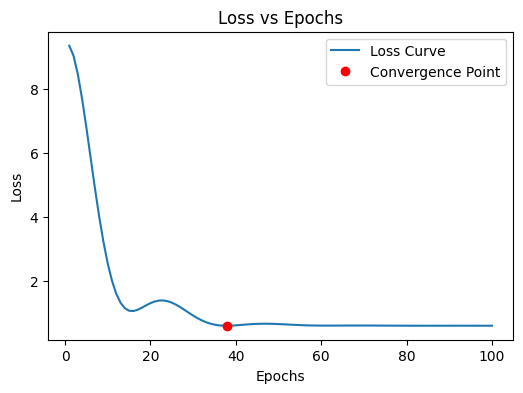

In [22]:
res = full_batch_gd_momentum(
    x_tensor, y_tensor,
    alpha=0.01,momentum=0.9, epochs=100, epsilon=0.001,
    start_theta=(1.0, 1.0), min_loss=min_loss
)
print(res["converge_epoch"])
print(res["converge_loss"])
# Plot results
plot_loss_vs_epoch(res["loss_dict"], res["converge_epoch"], res["converge_loss"])

### Contour Plot for Full Batch Gradient Descent with momentum = 0.9

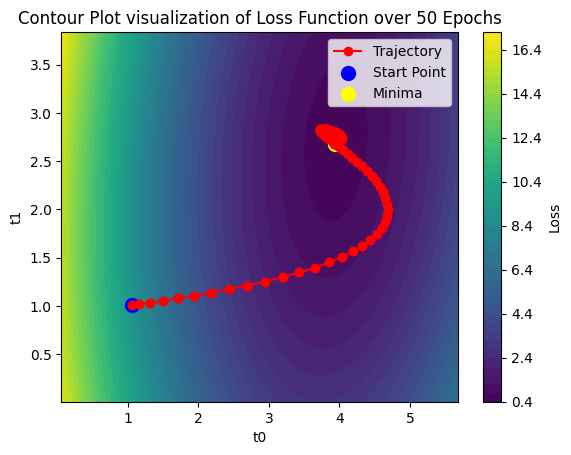

C:\Users\seema\AppData\Local\Temp\ipykernel_16872\3835177526.py:82: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved permanently at: results\trajectory_bgd_momentum.gif


In [24]:
t0_values = res['t0_values']
t1_values = res['t1_values']
loss_values = res['loss_values']

# If you want the final minimum point
min_t0 = res['final_t0']
min_t1 = res['final_t1']
t0_grid = np.linspace(min(t0_values) - 1, max(t0_values) + 1, 100)
t1_grid = np.linspace(min(t1_values) - 1, max(t1_values) + 1, 100)
T0, T1 = np.meshgrid(t0_grid, t1_grid)

# Calculate the loss function at each point of the grid
loss_grid = np.zeros_like(T0)
for i in range(len(t0_grid)):
    for j in range(len(t1_grid)):
        loss_grid[i, j] = np.mean((y - (T0[i, j] + T1[i, j] * x1)) ** 2)

# Plotting the contour map
plt.contourf(T0, T1, loss_grid, levels=50, cmap='viridis')
plt.colorbar(label='Loss')

# Plot the trajectory of t0 and t1 during the 2500 epochs
plt.plot(t0_values, t1_values, marker='o', color='red', label='Trajectory')
plt.scatter(t0_values, t1_values, c='red')
plt.xlabel("t0")
plt.ylabel("t1")
plt.title("Contour Plot visualization of Loss Function over 50 Epochs")
plt.legend()

# Mark the starting point and the minima point
plt.scatter(t0_values[0], t1_values[0], c='blue', s=100, label='Start Point')  # Start
plt.scatter(min_t0, min_t1, c='yellow', s=100, label='Minima')  # Minima

plt.legend()
plt.show()



# Create a folder to store frames temporarily
frames_folder = "trajectory_frames"
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

filenames = []

# Plot the trajectory of t0 and t1 during the first 15 epochs
for i in range(15):
    plt.contourf(T0, T1, loss_grid, levels=50, cmap='viridis')
    plt.colorbar(label='Loss')
    
    # Plot trajectory
    plt.plot(t0_values[0:i+1], t1_values[0:i+1], marker='o', color='red', label='Trajectory')
    plt.scatter(t0_values[0:i+1], t1_values[0:i+1], c='red')
    
    plt.xlabel("t0")
    plt.ylabel("t1")
    plt.title(f"Contour Plot of Loss Function over {i+1} Epochs")
    
    # Mark the starting point and the ending point (minimized point)
    plt.scatter(t0_values[0], t1_values[0], c='blue', s=100, label='Start Point')  # Start
    plt.scatter(t0_values[-1], t1_values[-1], c='yellow', s=100, label='Minima')  # Minima

    plt.legend()
    
    # Save the frame
    filename = os.path.join(frames_folder, f"frame_{i:03d}.png")
    plt.savefig(filename)
    filenames.append(filename)
    
    plt.close()

# Create a folder to store the final GIF permanently
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

gif_filename = os.path.join(results_folder, "trajectory_bgd_momentum.gif")

# Create the GIF
with imageio.get_writer(gif_filename, mode='I', duration=0.5, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cleanup temporary frames

try:
    for filename in filenames:
        os.remove(filename)
    shutil.rmtree(frames_folder, ignore_errors=True)
    print(f"GIF saved permanently at: {gif_filename}")
except Exception as e:
    print(f"Cleanup failed: {e}")



In [25]:

# res_momentum is the dictionary returned by your momentum GD function
df = pd.DataFrame({
    "epoch": list(res["loss_dict"].keys()),
    "t0": res["t0_values"],
    "t1": res["t1_values"],
    "t0_grad": res["t0_grad"],
    "t1_grad": res["t1_grad"],
    "velocity_t0": res["velocity_t0"],
    "velocity_t1": res["velocity_t1"],
    "loss": res["loss_values"]
})

# Add an iteration column if you want 1-to-1 with rows
df["iteration"] = range(1, len(df) + 1)
df.set_index("iteration", inplace=True)

display(df)


,epoch,t0,t1,t0_grad,t1_grad,velocity_t0,velocity_t1,loss
iteration,,,,,,,,
1,1,1.056164,1.005630,-5.616435,-0.562997,-0.056164,-0.005630,9.355592
2,2,1.161763,1.016387,-5.505060,-0.568954,-0.105599,-0.010757,9.040090
3,3,1.309758,1.031868,-5.295684,-0.580046,-0.147996,-0.015481,8.463638
4,4,1.492977,1.051754,-5.002316,-0.595334,-0.183219,-0.019887,7.692512
5,5,1.704267,1.075790,-4.639246,-0.613806,-0.211290,-0.024036,6.797230
...,...,...,...,...,...,...,...,...
96,96,3.932266,2.677953,-0.038730,0.000973,-0.001242,0.000778,0.596133
97,97,3.933745,2.677250,-0.036115,0.000271,-0.001479,0.000703,0.596087
98,98,3.935406,2.676621,-0.033038,-0.000424,-0.001661,0.000629,0.596035


### Average Convergence Steps for Full Batch Gradient Descent with momentum= 0.9

In [26]:
def average_convergence_mom(x, y, start_points, alpha=0.01, momentum=0.9, epochs=1000, epsilon=1e-3, min_loss=None):
    total_epochs = 0
    valid_runs = 0

    for start_theta in start_points:
        result = full_batch_gd_momentum(x, y, 0.01, 0.9, 100, 0.001, start_theta, min_loss)

        if result["converge_epoch"] is not None:
            total_epochs += result["converge_epoch"]
            valid_runs += 1

    avg_steps = total_epochs / valid_runs if valid_runs > 0 else None
    print(f" Average convergence steps across {valid_runs} runs: {avg_steps}")
    return avg_steps

In [27]:
start_thetas = [(np.random.uniform(-5, 5), np.random.uniform(-5, 5)) for _ in range(5)]
average_convergence_mom(x_tensor, y_tensor, start_thetas, momentum=0.9, alpha=0.01, epochs=100, epsilon=0.001, min_loss=min_loss)

 Average convergence steps across 5 runs: 37.6


37.6

### Stochastic Gradient Descent with momentum=0.9

In [28]:
def stochastic_gd_momentum(x, y, alpha=0.005, momentum=0.7, epochs=50, epsilon=1e-3, start_theta=(1.0, 1.0), min_loss=None):
    """
    Performs Stochastic Gradient Descent (SGD) with Momentum on y = t0 + t1*x
    Returns trajectory, loss dict, gradients, velocities, and convergence info
    """
    num_samples = len(x)
    
    # Initialize parameters
    t0 = torch.tensor(start_theta[0], requires_grad=True)
    t1 = torch.tensor(start_theta[1], requires_grad=True)
    
    # Initialize velocities
    v_t0 = 0.0
    v_t1 = 0.0
    
    # Lists to store trajectory and other info
    t0_values, t1_values, loss_values = [], [], []
    dt0_values, dt1_values = [], []
    t0_grad, t1_grad = [], []
    velocity_t0, velocity_t1 = [], []
    epoch_values = []
    loss_dict = {}
    
    for epoch in range(epochs):
        for i in range(num_samples):
            # Compute per-sample loss
            yp = t0 + t1 * x[i]
            loss = (y[i] - yp) ** 2
            loss.backward()
            
            # Update parameters with momentum
            with torch.no_grad():
                v_t0 = momentum * v_t0 + alpha * t0.grad
                v_t1 = momentum * v_t1 + alpha * t1.grad
                
                t0 -= v_t0
                t1 -= v_t1
                
                # Store gradients and velocities
                t0_grad.append(t0.grad.item())
                t1_grad.append(t1.grad.item())
                velocity_t0.append(v_t0.item())
                velocity_t1.append(v_t1.item())
                
                dt0_values.append(t0.item())
                dt1_values.append(t1.item())
                
                # Epoch tracking
                if i < num_samples - 1:
                    epoch_values.append(epoch)
                else:
                    epoch_values.append(epoch + 1)
                
                # Zero gradients for next iteration
                t0.grad.zero_()
                t1.grad.zero_()
        
        # Full dataset loss after each epoch
        yp_full = t0 + t1 * x
        full_loss = torch.mean((y - yp_full) ** 2)
        loss_dict[epoch] = full_loss.item()
        
        # Store trajectory for contour plotting
        t0_values.append(t0.item())
        t1_values.append(t1.item())
        loss_values.append(full_loss.item())
    
    # Convergence detection
    converge_epoch, converge_loss = None, None
    if min_loss is not None:
        for epoch_key in loss_dict.keys():
            if abs(loss_dict[epoch_key] - min_loss) <= epsilon:
                converge_epoch = epoch_key
                converge_loss = loss_dict[epoch_key]
                break
    
    return {
        "t0_values": t0_values,
        "t1_values": t1_values,
        "loss_values": loss_values,
        "loss_dict": loss_dict,
        "dt0_values": dt0_values,
        "dt1_values": dt1_values,
        "t0_grad": t0_grad,
        "t1_grad": t1_grad,
        "velocity_t0": velocity_t0,
        "velocity_t1": velocity_t1,
        "epoch_values": epoch_values,
        "final_t0": t0.item(),
        "final_t1": t1.item(),
        "converge_epoch": converge_epoch,
        "converge_loss": converge_loss
    }


None None


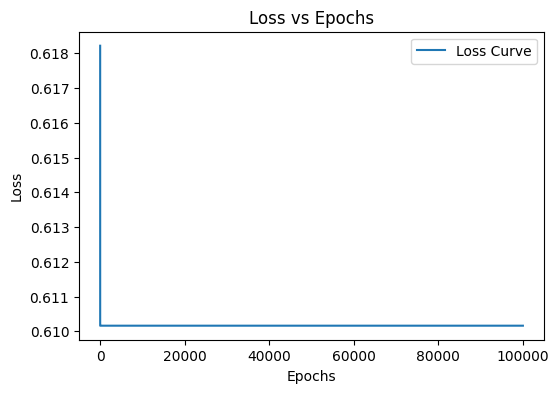

In [30]:
res = stochastic_gd_momentum(
    x_tensor, y_tensor,
    alpha=0.01,momentum=0.9, epochs=100000, epsilon=0.001,
    start_theta=(1.0, 1.0), min_loss=min_loss
)
print(res["converge_epoch"], res["converge_loss"])
# Plot results
plot_loss_vs_epoch(res["loss_dict"], res["converge_epoch"], res["converge_loss"])

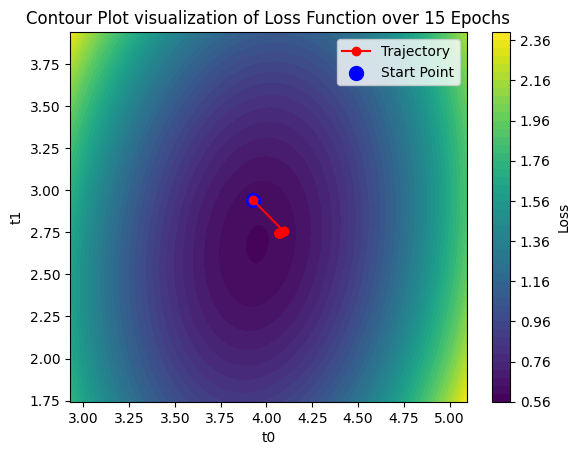

C:\Users\seema\AppData\Local\Temp\ipykernel_16872\1241512859.py:82: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved permanently at: results\trajectory_sgd_momentum_alpha_0.01.gif


In [32]:
t0_values = res['t0_values']
t1_values = res['t1_values']
loss_values = res['loss_values']

# If you want the final minimum point
min_t0 = res['final_t0']
min_t1 = res['final_t1']
t0_grid = np.linspace(min(t0_values) - 1, max(t0_values) + 1, 100)
t1_grid = np.linspace(min(t1_values) - 1, max(t1_values) + 1, 100)
T0, T1 = np.meshgrid(t0_grid, t1_grid)

# Calculate the loss function at each point of the grid
loss_grid = np.zeros_like(T0)
for i in range(len(t0_grid)):
    for j in range(len(t1_grid)):
        loss_grid[i, j] = np.mean((y - (T0[i, j] + T1[i, j] * x1)) ** 2)

# Plotting the contour map
plt.contourf(T0, T1, loss_grid, levels=50, cmap='viridis')
plt.colorbar(label='Loss')

# Plot the trajectory of t0 and t1 during the 2500 epochs
plt.plot(t0_values, t1_values, marker='o', color='red', label='Trajectory')
plt.scatter(t0_values, t1_values, c='red')
plt.xlabel("t0")
plt.ylabel("t1")
plt.title("Contour Plot visualization of Loss Function over 15 Epochs")
plt.legend()

# Mark the starting point and the minima point
plt.scatter(t0_values[0], t1_values[0], c='blue', s=100, label='Start Point')  # Start
#plt.scatter(min_t0, min_t1, c='yellow', s=100, label='Minima')  # Minima

plt.legend()
plt.show()



# Create a folder to store frames temporarily
frames_folder = "trajectory_frames"
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

filenames = []

# Plot the trajectory of t0 and t1 during the first 15 epochs
for i in range(15):
    plt.contourf(T0, T1, loss_grid, levels=50, cmap='viridis')
    plt.colorbar(label='Loss')
    
    # Plot trajectory
    plt.plot(t0_values[0:i+1], t1_values[0:i+1], marker='o', color='red', label='Trajectory')
    plt.scatter(t0_values[0:i+1], t1_values[0:i+1], c='red')
    
    plt.xlabel("t0")
    plt.ylabel("t1")
    plt.title(f"Contour Plot of Loss Function over {i+1} Epochs")
    
    # Mark the starting point and the ending point (minimized point)
    plt.scatter(t0_values[0], t1_values[0], c='blue', s=100, label='Start Point')  # Start
    #plt.scatter(t0_values[-1], t1_values[-1], c='yellow', s=100, label='Minima')  # Minima

    plt.legend()
    
    # Save the frame
    filename = os.path.join(frames_folder, f"frame_{i:03d}.png")
    plt.savefig(filename)
    filenames.append(filename)
    
    plt.close()

# Create a folder to store the final GIF permanently
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

gif_filename = os.path.join(results_folder, "trajectory_sgd_momentum_alpha_0.01.gif")

# Create the GIF
with imageio.get_writer(gif_filename, mode='I', duration=0.5, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cleanup temporary frames
try:
    for filename in filenames:
        os.remove(filename)
    shutil.rmtree(frames_folder, ignore_errors=True)
    print(f"GIF saved permanently at: {gif_filename}")
except Exception as e:
    print(f"Cleanup failed: {e}")


We observe that stochastic gradient descent with momentum (momentum = 0.9) and a learning rate of 0.01 fails to satisfy the convergence criterion even after 100000 epochs. This happens because the stochastic nature of the algorithm introduces high variance in gradient estimates, causing noisy and fluctuating updates. With a relatively large learning rate, these fluctuations get amplified through the accumulated momentum term, leading to oscillations around the optimum rather than stable convergence. We have decided to reduce the learning rate in order to observe convergence.

### With learning rate=0.001
### Plot of Loss vs Epochs for Stochastic Gradient Descent with momentum = 0.9

13 0.5965090834935887


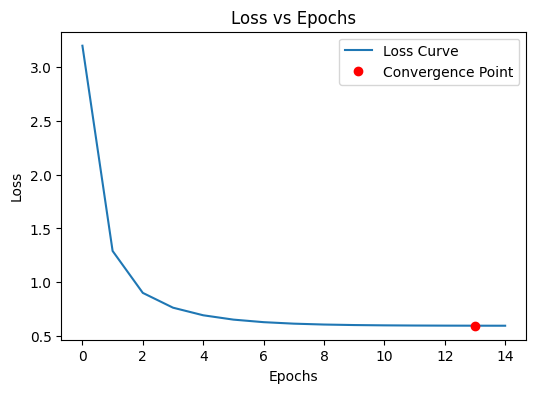

In [34]:
res = stochastic_gd_momentum(
    x_tensor, y_tensor,
    alpha=0.001,momentum=0.9, epochs=15, epsilon=0.001,
    start_theta=(1.0, 1.0), min_loss=min_loss
)
print(res["converge_epoch"], res["converge_loss"])
# Plot results
plot_loss_vs_epoch(res["loss_dict"], res["converge_epoch"], res["converge_loss"])

### Contour Plot for Stochastic Gradient Descent with momentum = 0.9

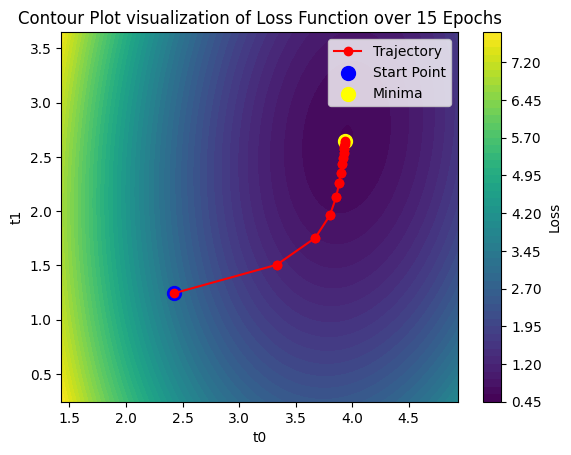

C:\Users\seema\AppData\Local\Temp\ipykernel_16872\3073285957.py:82: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved permanently at: results\trajectory_sgd_momentum_alpha_0.001.gif


In [36]:
t0_values = res['t0_values']
t1_values = res['t1_values']
loss_values = res['loss_values']

# If you want the final minimum point
min_t0 = res['final_t0']
min_t1 = res['final_t1']
t0_grid = np.linspace(min(t0_values) - 1, max(t0_values) + 1, 100)
t1_grid = np.linspace(min(t1_values) - 1, max(t1_values) + 1, 100)
T0, T1 = np.meshgrid(t0_grid, t1_grid)

# Calculate the loss function at each point of the grid
loss_grid = np.zeros_like(T0)
for i in range(len(t0_grid)):
    for j in range(len(t1_grid)):
        loss_grid[i, j] = np.mean((y - (T0[i, j] + T1[i, j] * x1)) ** 2)

# Plotting the contour map
plt.contourf(T0, T1, loss_grid, levels=50, cmap='viridis')
plt.colorbar(label='Loss')

# Plot the trajectory of t0 and t1 during the 2500 epochs
plt.plot(t0_values, t1_values, marker='o', color='red', label='Trajectory')
plt.scatter(t0_values, t1_values, c='red')
plt.xlabel("t0")
plt.ylabel("t1")
plt.title("Contour Plot visualization of Loss Function over 15 Epochs")
plt.legend()

# Mark the starting point and the minima point
plt.scatter(t0_values[0], t1_values[0], c='blue', s=100, label='Start Point')  # Start
plt.scatter(min_t0, min_t1, c='yellow', s=100, label='Minima')  # Minima

plt.legend()
plt.show()



# Create a folder to store frames temporarily
frames_folder = "trajectory_frames"
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

filenames = []

# Plot the trajectory of t0 and t1 during the first 15 epochs
for i in range(15):
    plt.contourf(T0, T1, loss_grid, levels=50, cmap='viridis')
    plt.colorbar(label='Loss')
    
    # Plot trajectory
    plt.plot(t0_values[0:i+1], t1_values[0:i+1], marker='o', color='red', label='Trajectory')
    plt.scatter(t0_values[0:i+1], t1_values[0:i+1], c='red')
    
    plt.xlabel("t0")
    plt.ylabel("t1")
    plt.title(f"Contour Plot of Loss Function over {i+1} Epochs")
    
    # Mark the starting point and the ending point (minimized point)
    plt.scatter(t0_values[0], t1_values[0], c='blue', s=100, label='Start Point')  # Start
    plt.scatter(t0_values[-1], t1_values[-1], c='yellow', s=100, label='Minima')  # Minima

    plt.legend()
    
    # Save the frame
    filename = os.path.join(frames_folder, f"frame_{i:03d}.png")
    plt.savefig(filename)
    filenames.append(filename)
    
    plt.close()

# Create a folder to store the final GIF permanently
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

gif_filename = os.path.join(results_folder, "trajectory_sgd_momentum_alpha_0.001.gif")

# Create the GIF
with imageio.get_writer(gif_filename, mode='I', duration=0.5, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cleanup temporary frames
try:
    for filename in filenames:
        os.remove(filename)
    shutil.rmtree(frames_folder, ignore_errors=True)
    print(f"GIF saved permanently at: {gif_filename}")
except Exception as e:
    print(f"Cleanup failed: {e}")


### Average Convergence Steps for Stochastic Gradient Descent with momentum =0.9

In [37]:
def average_convergence_sgd_momentum(x, y, start_points, alpha=0.005, momentum=0.7,epochs=50, epsilon=1e-3, min_loss=None):
    total_steps = 0
    valid_runs = 0

    for start_theta in start_points:
        result = stochastic_gd_momentum(x, y, 0.005, 0.7, 50, 0.001, start_theta, min_loss)
        if result["converge_epoch"] is not None:
            total_steps += num_samples*result["converge_epoch"]
            valid_runs += 1

    avg_steps = total_steps / valid_runs if valid_runs > 0 else None
    print(f"Average convergence steps across {valid_runs} runs: {avg_steps}")
    return avg_steps

In [38]:
start_thetas = [(np.random.uniform(-5, 5), np.random.uniform(-5, 5)) for _ in range(5)]
average_convergence_sgd_momentum(x_tensor, y_tensor, start_thetas, momentum=0.7, alpha=0.005, epochs=100, epsilon=0.001, min_loss=min_loss)

Average convergence steps across 5 runs: 328.0


328.0

In [39]:
df_iter = pd.DataFrame({
    "t0": res["dt0_values"],
    "t1": res["dt1_values"],
    "t0_grad": res["t0_grad"],
    "t1_grad": res["t1_grad"],
    "velocity_t0": res["velocity_t0"],
    "velocity_t1": res["velocity_t1"],
    "epoch": res["epoch_values"]
})
df_iter["iteration"] = range(1, len(df_iter) + 1)
df_iter.set_index("iteration", inplace=True)
display(df_iter)


,t0,t1,t0_grad,t1_grad,velocity_t0,velocity_t1,epoch
iteration,,,,,,,
1,1.008050,1.007873,-8.050039,-7.873124,-0.008050,-0.007873,0
2,1.023896,1.015811,-8.600670,-0.852236,-0.015846,-0.007938,0
3,1.041995,1.021278,-3.838243,1.677717,-0.018099,-0.005467,0
4,1.063412,1.021863,-5.127123,4.334577,-0.021417,-0.000585,0
5,1.087012,1.021909,-4.325634,0.480409,-0.023601,-0.000046,0
...,...,...,...,...,...,...,...
596,3.929792,2.646516,0.665943,-0.332931,-0.001286,-0.001677,14
597,3.929688,2.648132,1.261889,-0.106660,0.000104,-0.001616,14
598,3.930444,2.649684,-0.849679,-0.097599,-0.000756,-0.001552,14


### Observations on Vanilla Gradient Descent

When computing the average number of steps required for each method to converge, it is observed that the stochastic gradient descent (SGD) method takes more steps than full-batch gradient descent (BGD) . Although SGD may require fewer epochs to converge, each epoch involves updating the parameters after every sample, making the total number of steps (i.e., parameter updates) much higher. This frequent updating causes the loss function to fluctuate significantly around the minimum due to the high variance in gradient estimates from individual samples.

In contrast, the full-batch gradient descent (BGD) method updates the parameters only once per epoch after processing the entire dataset, resulting in fewer total steps and a smoother, more stable convergence curve. This reduces fluctuations in the loss function and allows a more consistent approach toward the global minimum.

From the experimental results averaged across 5 runs:

The average number of steps for full-batch gradient descent to converge is ≈ 554.6 steps.

The average number of steps for stochastic gradient descent to converge is ≈ 688 steps.

However, considering computation time, SGD generally converges faster in practice, as each step requires processing only a single sample, making individual updates significantly quicker than those in BGD. Thus, while BGD is more stable, SGD achieves practical convergence more rapidly due to its frequent but lightweight updates.

### Observations on Gradient Descent with Momentum

When computing the average number of steps required for each method with momentum to converge, it is observed that adding momentum significantly reduces the total number of steps compared to the vanilla methods. The momentum term incorporates a fraction of the previous update into the current update, which helps the optimization maintain direction and reduces oscillations in the loss function. This effect, similar to inertia in physics, allows the optimizer to move more smoothly and consistently toward the minimum, resulting in faster convergence.

The average number of steps for full-batch gradient descent with momentum to converge is ≈ 37.6 steps much lesser than steps required for vanilla BGD (554.6).

However, when using SGD with a high momentum coefficient (0.9) and the same learning rate as the vanilla cases (0.01), the optimization failed to converge even after 100,000 epochs. This occurs because the combination of a large learning rate and strong momentum causes excessively large parameter updates. The optimizer overshoots the minimum repeatedly, leading to divergence and instability in the loss function. By reducing the learning rate to 0.001, the updates became smaller and more controlled, allowing the benefits of momentum to accelerate convergence without destabilizing the optimization. With this adjustment, the average number of steps reduced to 328 compared to vanilla SGD (688)—demonstrating that momentum can dramatically improve convergence speed when paired with an appropriate learning rate.

Observation on Dataset Scaling

It is observed that all optimization methods required more steps to converge on Dataset 1 compared to Dataset 2. This difference arises primarily due to the scale of the input features and target values. In Dataset 1, the inputs range from -20 to 20 and the target values are scaled by 100, producing large gradients during optimization. These large gradients cause the parameter updates to be more volatile, leading to oscillations around the minimum and requiring more steps for the optimizer to stabilize. In contrast, Dataset 2 has inputs ranging from -1 to 1 and smaller target values, resulting in smaller and more stable gradients. This allows the optimizer to take proportionate steps toward convergence, reducing the total number of steps required. Thus, feature and target scaling significantly affect the convergence behavior of gradient-based optimization methods.